In [128]:
import pandas as pd
from datetime import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from scipy.stats import wilcoxon

In [129]:
folderpath = "../../Data/QMEF/"

df = pd.read_csv(folderpath + 'BTCUSDT.csv', sep='|', header=None)

# https://www.cryptoarchive.com.au/faq
df.columns = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Taker Buy Quote Asset Volume', 
                'Taker Buy Base Asset Volume', 'Quote Asset Volume', 'Number of trades']

df

,timestamp,Open,High,Low,Close,Volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
0,1502942400,4261.48,4261.48,4261.48,4261.48,1.775183,320.390851,0.075183,7564.906851,3
1,1502942460,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0.000000,0.000000,0
2,1502942520,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,0.261074,1117.542921,2
3,1502942580,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,0.012008,51.171852,3
4,1502942640,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,0.140796,599.999338,1
...,...,...,...,...,...,...,...,...,...,...
3120426,1690681620,29325.90,29325.91,29325.90,29325.91,1.199590,5545.822840,0.189110,35179.058270,108
3120427,1690681680,29325.91,29325.91,29324.60,29324.72,3.922770,34683.135800,1.182680,115038.629410,140
3120428,1690681740,29324.72,29324.73,29324.72,29324.72,0.562730,10083.601660,0.343860,16501.903120,106
3120429,1690681800,29324.73,29327.67,29324.72,29327.67,3.839800,98416.039460,3.355980,112605.116370,235


In [130]:
df_tweets = pd.read_csv("../../Data/QMEF/btc_tweet_analysis.csv", sep=";", encoding='utf8', parse_dates=['CreatedAt', 'UTC'])
df_tweets.drop_duplicates('TweetId', inplace = True)

df_tweets['timestamp'] = df_tweets['UTC'].apply(lambda x: x.astype('int')//10**9)
df_tweets['timestamp'] = df_tweets['timestamp'] - (df_tweets['timestamp'] % 60) #Abrunden auf Minuten

df_tweets = df_tweets[['UTC', 'timestamp', 'Text', 'Favorites', 'Retweets', 'neg', 'neu', 'pos', 'compound']]

df_tweets['UTC'] = pd.to_datetime(df_tweets['UTC'])

# Zeitdauer von 6 Stunden
time_threshold = timedelta(hours=6)

# Liste für Zeilen, die behalten werden sollen
df_tweets_relevant = []

# Iteriere über jeden Eintrag im DataFrame
for index, row in df_tweets.iterrows():
    utc_time = row['UTC']
    
    # Überprüfe die Differenz zur 'UTC'-Spalte aller anderen Einträge
    time_difference = abs(df_tweets.loc[df_tweets.index != index, 'UTC'] - utc_time)
    
    # Wenn die Differenz größer oder gleich 6 Stunden ist, behalte den Eintrag
    if (time_difference >= time_threshold).all():
        df_tweets_relevant.append(index)

# Filtere den DataFrame nach den ausgewählten Zeilen
df_tweets_relevant = df_tweets.loc[df_tweets_relevant]
pd.set_option('display.max_colwidth', None)
print(df_tweets_relevant.sort_values(by='UTC'))


                        UTC   timestamp  \
1 2020-11-16 22:02:51+00:00  1605564120   
2 2021-02-08 05:27:36+00:00  1612762020   
0 2021-02-20 07:02:06+00:00  1613804520   
4 2021-03-12 18:58:22+00:00  1615575480   
3 2021-04-26 23:15:01+00:00  1619478900   
7 2021-05-12 22:06:14+00:00  1620857160   

                                                                                                                                                                                                                                         Text  \
1                                                                                                                                                                                           @Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶   
2  @itsALLrisky Doge appears to be inflationary, but is not meaningfully so (fixed # of coins per unit time), whereas BTC is arguably deflationary to a fault.  Transaction speed of Doge should ideally be a few orders

In [133]:
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))

ar_ges = pd.DataFrame(columns=['AR_0', 'AR_1', 'AR_2', 'AR_3', 'AR_4', 'AR_5', 'AR_6', 'AR_7', 'AR_8', 'AR_9', 'AR_10', ])
car_ges = pd.DataFrame(columns = ['CAR_1', 'CAR_2', 'CAR_5', 'CAR_10', 'CAR_30', 'CAR_60', 'CAR_120'])
cum_abnormal_returns_all = []


for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    btc_sliced = df[(df['timestamp'] >= timestamp-360*60) & (df['timestamp'] <= timestamp+120*60)]

    # Es werden nach Tweets gesucht, die 240 Minuten vor und 100 Minuten nach dem Event stattgefunden haben.
    # tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-240*60) & (df_tweets['timestamp'] <= timestamp+100*60)]
    
    # Ausrechnen der Renditen
    btc_sliced['log_returns'] = np.log(btc_sliced['Close'] / btc_sliced['Close'].shift(1))
    # Erste Rendite wird 0 gesetzt
    btc_sliced.loc[0, 'log_returns'] = 0
    # Kumulierte Renditen
    btc_sliced['cum_log_returns'] = np.cumsum(btc_sliced['log_returns'])

    # Expected Returns which are based on the mean value of the returns of the last 5 hours before the tweet.
    # Event Takes place at t=360
    expected_return = np.mean(btc_sliced['log_returns'].iloc[1:301]) # Fehler bei Ante, da Ante 1:301 nimmt und nicht 0:300
    print('Expected Return = ', expected_return)
    
    # Abnormal Returns based on After Returns - Mean Value of Returns (before Tweet)
    btc_sliced['abnormal_returns'] = btc_sliced['log_returns'] - expected_return
    btc_sliced['abnormal_returns_cum'] = np.cumsum(btc_sliced['abnormal_returns'])
    btc_sliced['abnormal_returns_cum'].iloc[0] = 0

    cum_abnormal_returns_all.append(btc_sliced['abnormal_returns_cum'].values)

    ar_values = []
    for event_horizon in range(11):
        ar_values.append(btc_sliced['abnormal_returns'].iloc[360+event_horizon])
    ar_ges = pd.concat([ar_ges, pd.DataFrame([ar_values], columns=ar_ges.columns)], ignore_index=True)


    car_values = []
    for event_horizon in [1, 2, 5, 10, 30, 60, 120]:
        car_values.append(btc_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].sum())
    car_ges = pd.concat([car_ges, pd.DataFrame([car_values], columns=car_ges.columns)], ignore_index=True)

    # T-Statistiken für [1, 5, 10, 30, 60, 120]
    for event_horizon in [1, 5, 10, 30, 60, 120]:
        print(f'T[0; {event_horizon}] = ', (btc_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].mean() / btc_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1)) # <-- richtiger Wert
        
    # fig = plt.figure(1, figsize = (25, 11))
    # plt.plot(btc_sliced["Date"], btc_sliced['cum_log_returns'], lw=2, label='Cumulative Returns')
    # plt.plot(btc_sliced["Date"], btc_sliced['abnormal_returns_cum'], lw=2, label='Cumulative Abnormal Returns', color='darkred')
    # plt.vlines(dt.fromtimestamp(timestamp), label='Tweet', ymin=btc_sliced['cum_log_returns'].min()*1.2, ymax=btc_sliced['cum_log_returns'].max()*1.2, colors='red', lw=2) 

    # if len(tweets_sliced) > 1:
    #     plt.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=btc_sliced['abnormal_returns_cum'].max()*1.2, colors='orange', lw=2) 
    # plt.axhline(0, color = 'black')
    # plt.legend(loc='best', fontsize=20)
    # plt.title('Cumulative Returns', size=25)

    # plt.show()

print('ar_frame:')
print(ar_ges)

print('car_frame:')
print(car_ges)

Expected Return =  -4.4900623832960184e-05
T[0; 1] =  -2.836445994005796
T[0; 5] =  -3.094643583714738
T[0; 10] =  -3.734198940157742
T[0; 30] =  -0.9604948393673636
T[0; 60] =  -0.9437074988672255
T[0; 120] =  -0.5544413551598847
Expected Return =  7.48480378579025e-05
T[0; 1] =  -0.2556507008871264
T[0; 5] =  -0.26290013071478296
T[0; 10] =  -0.7462742483472293
T[0; 30] =  -0.45883013295583497
T[0; 60] =  -0.5101396371500473
T[0; 120] =  -1.1265496458902193
Expected Return =  -3.277347509483498e-05
T[0; 1] =  0.08981227202905842
T[0; 5] =  0.6144135280426424
T[0; 10] =  1.191650123233049
T[0; 30] =  0.4590816956017414
T[0; 60] =  2.2968312558025494
T[0; 120] =  1.4921177983014473
Expected Return =  1.6185860934175017e-05
T[0; 1] =  1.9680084838667056
T[0; 5] =  0.7847762301302431
T[0; 10] =  0.8405360578491634
T[0; 30] =  0.6897716937004076
T[0; 60] =  0.004922454196945295
T[0; 120] =  0.06369895437393511
Expected Return =  4.376896520752517e-05
T[0; 1] =  -0.00850697933021329
T[0; 5

In [134]:
cum_abnormal_returns_all = pd.DataFrame(cum_abnormal_returns_all)
cum_abnormal_returns_all.to_csv('cum_abnormal_returns_all_btc.csv', index=False)

In [135]:
ar_ges.to_csv('ar_ges_bitcoin.csv', index=False)
car_ges.to_csv('car_ges_bitcoin.csv', index=False)

In [136]:
for s in ar_ges.columns:
    print(s)
    print('mean: ', ar_ges[s].mean())
    print('pos: ', sum(ar_ges[s] > 0) / len(ar_ges[s]))
    print('t-stat: ' ,ar_ges[s].mean() / ar_ges[s].std() * np.sqrt(len(ar_ges[s])))

    test_statistic, p_value = wilcoxon(ar_ges[s], method='approx', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(ar_ges[s].mean()*100, 4), '\% & ', 
          np.round(ar_ges[s].mean() / ar_ges[s].std() * np.sqrt(len(ar_ges[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(ar_ges[s] > 0) / len(ar_ges[s])*100, 0)), '\%')
    print('\n')

AR_0
mean:  -0.00019618762864682528
pos:  0.5
t-stat:  -0.41243406515580394
z-stat: 10.0
p-Wert: 0.916511907863894
-0.0196 \% &  -0.41  &  10.0  &  50 \%


AR_1
mean:  -0.0015235489617774524
pos:  0.5
t-stat:  -0.6468329538450933
z-stat: 10.0
p-Wert: 0.916511907863894
-0.1524 \% &  -0.65  &  10.0  &  50 \%


AR_2
mean:  -0.002159698323375777
pos:  0.3333333333333333
t-stat:  -0.9209050687052388
z-stat: 7.0
p-Wert: 0.463071015014588
-0.216 \% &  -0.92  &  7.0  &  33 \%


AR_3
mean:  -0.0008880217192897825
pos:  0.3333333333333333
t-stat:  -0.9870922245971985
z-stat: 7.0
p-Wert: 0.463071015014588
-0.0888 \% &  -0.99  &  7.0  &  33 \%


AR_4
mean:  0.0013936595287770282
pos:  0.6666666666666666
t-stat:  1.0702157460786987
z-stat: 6.0
p-Wert: 0.3454475304692257
0.1394 \% &  1.07  &  6.0  &  67 \%


AR_5
mean:  -0.003460978430316211
pos:  0.16666666666666666
t-stat:  -1.433665121312901
z-stat: 1.0
p-Wert: 0.046399461870904594
-0.3461 \% &  -1.43  &  1.0  &  17 \%


AR_6
mean:  0.00031451910

c:\Users\ckopp\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [137]:
for s in car_ges.columns:
      print(s)
      print('mean: ', car_ges[s].mean())
      print('pos: ', sum(car_ges[s] > 0) / len(car_ges[s]))
      print('t-stat: ' ,car_ges[s].mean() / car_ges[s].std() * np.sqrt(len(car_ges[s])))

      test_statistic, p_value = wilcoxon(car_ges[s], method='approx', alternative='two-sided')

      # Gib die Teststatistik und den p-Wert aus
      print("z-stat:", test_statistic)
      print("p-Wert:", p_value)
      print(np.round(car_ges[s].mean()*100, 4), '\% & ', 
            np.round(car_ges[s].mean() / car_ges[s].std() * np.sqrt(len(car_ges[s])), 2), ' & ',
            np.round(test_statistic, 2), ' & ',
            int(np.round(sum(car_ges[s] > 0) / len(car_ges[s])*100, 0)), '\%')
      print('\n')

CAR_1
mean:  -0.0017197365904242777
pos:  0.3333333333333333
t-stat:  -0.7935784921292188
z-stat: 7.0
p-Wert: 0.463071015014588
-0.172 \% &  -0.79  &  7.0  &  33 \%


CAR_2
mean:  -0.0038794349138000553
pos:  0.5
t-stat:  -0.8804866248778958
z-stat: 10.0
p-Wert: 0.916511907863894
-0.3879 \% &  -0.88  &  10.0  &  50 \%


CAR_5
mean:  -0.00683477553462902
pos:  0.3333333333333333
t-stat:  -1.0644628639476859
z-stat: 6.0
p-Wert: 0.3454475304692257
-0.6835 \% &  -1.06  &  6.0  &  33 \%


CAR_10
mean:  -0.005577059562350107
pos:  0.3333333333333333
t-stat:  -1.1421633482301208
z-stat: 6.0
p-Wert: 0.3454475304692257
-0.5577 \% &  -1.14  &  6.0  &  33 \%


CAR_30
mean:  -0.009128062711456005
pos:  0.3333333333333333
t-stat:  -1.2889941009293875
z-stat: 4.0
p-Wert: 0.17295491798842066
-0.9128 \% &  -1.29  &  4.0  &  33 \%


CAR_60
mean:  -0.006039434762064209
pos:  0.3333333333333333
t-stat:  -0.9523667241780008
z-stat: 6.0
p-Wert: 0.3454475304692257
-0.6039 \% &  -0.95  &  6.0  &  33 \%


CAR

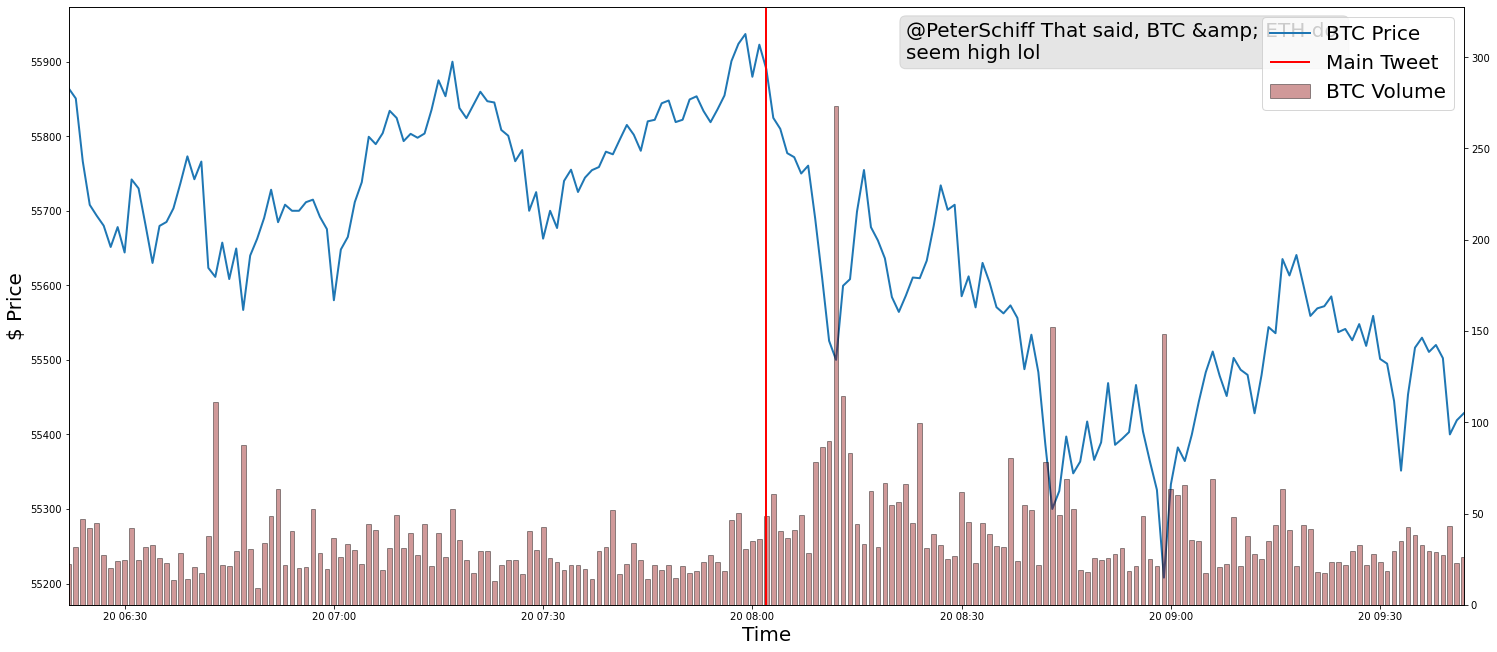

C:\Users\ckopp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


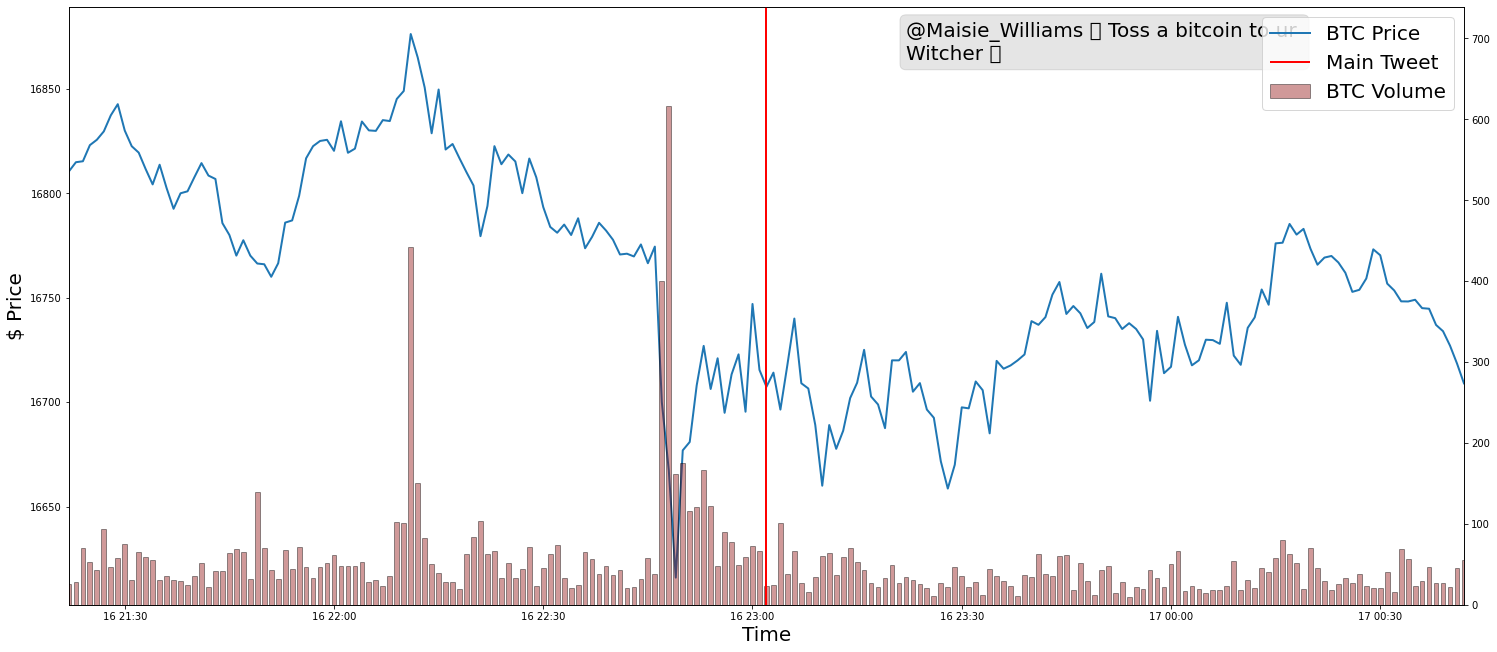

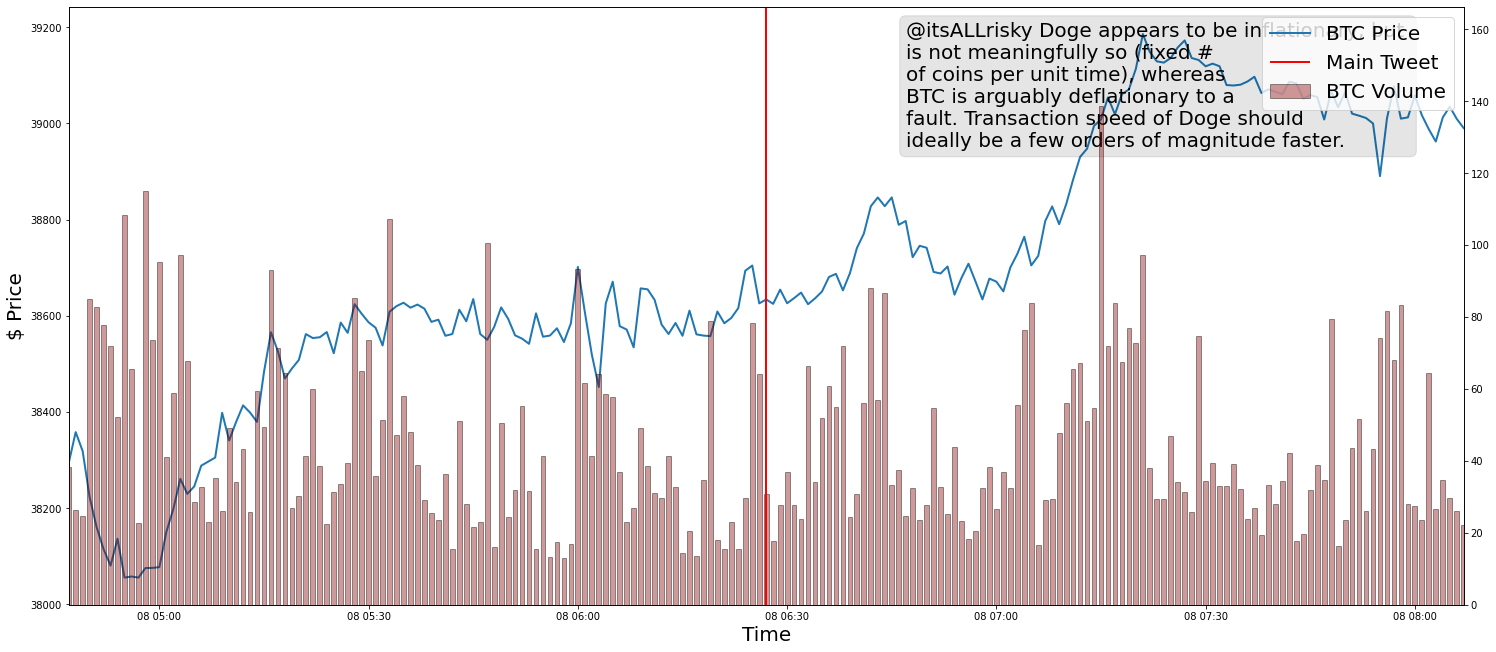

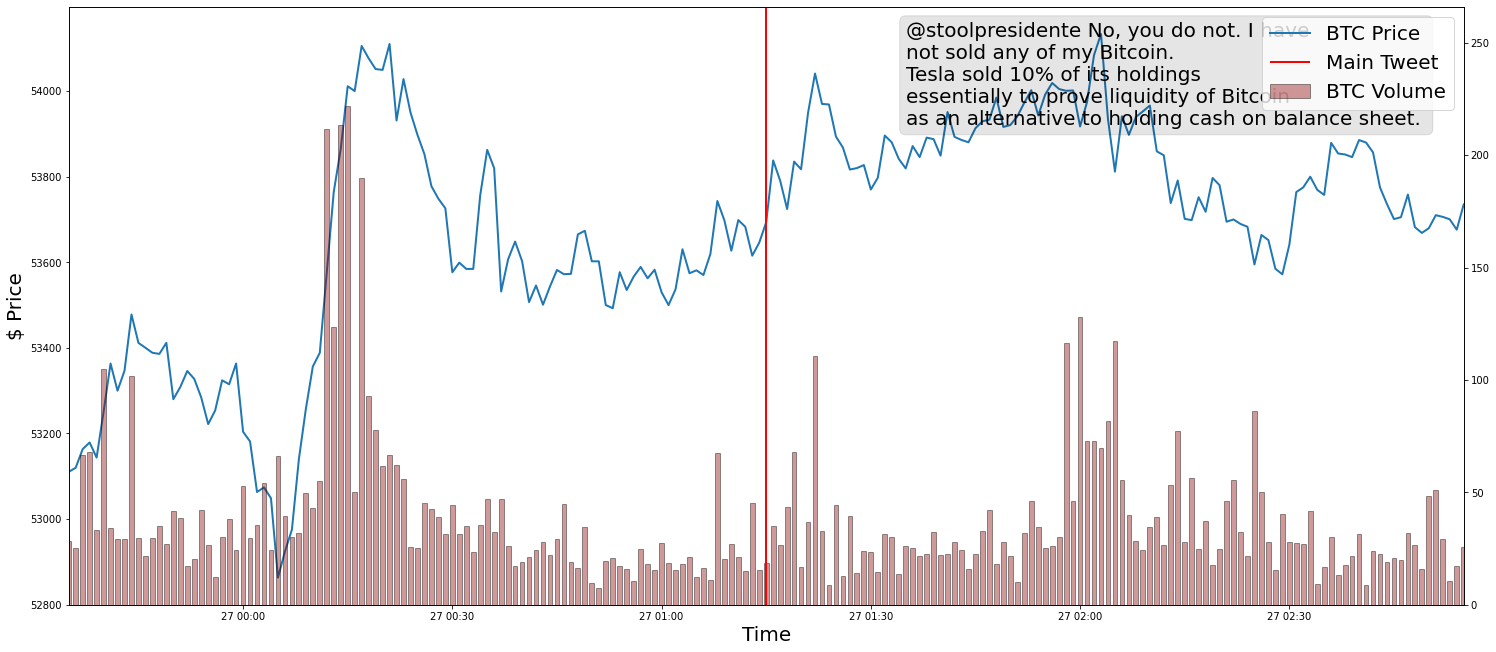

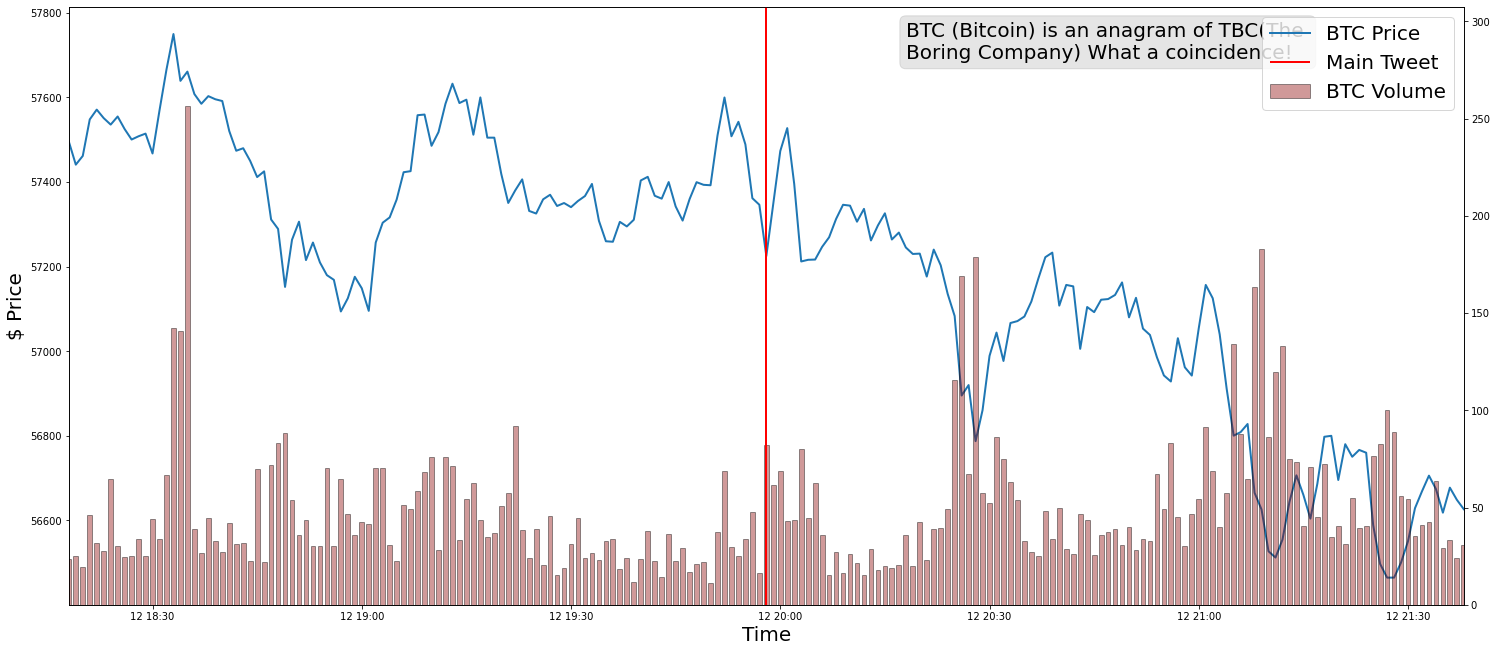

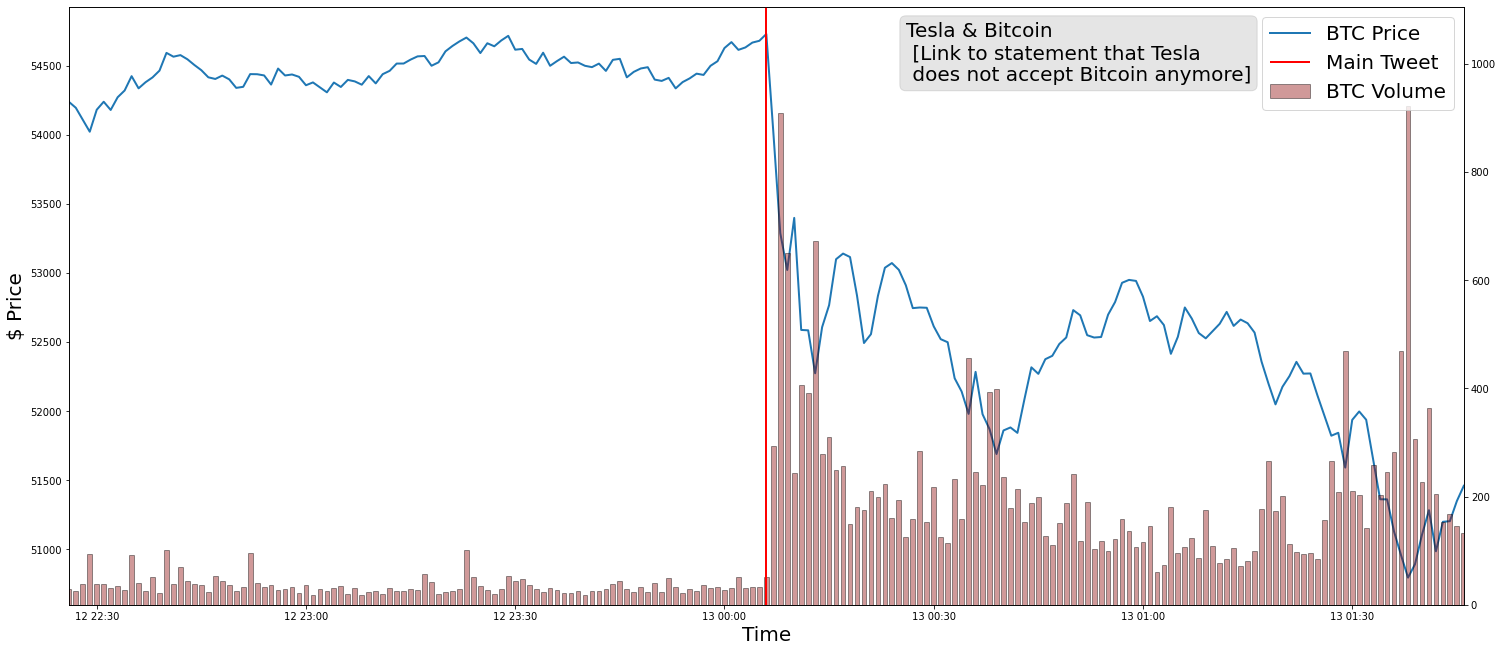

In [138]:
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    btc_sliced = df[(df['timestamp'] >= timestamp-100*60) & (df['timestamp'] <= timestamp+100*60)]
    tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-100*60) & (df_tweets['timestamp'] <= timestamp+100*60)]

    base_value = btc_sliced.iloc[0, 4]
    btc_sliced['CAR'] = btc_sliced['Close']/base_value

    fig = plt.figure(1, figsize = (25, 11))
    ax = fig.add_subplot(111)
    ax.plot(btc_sliced['Date'], btc_sliced['Close'], lw=2, label="BTC Price")

    ax2 = ax.twinx()
    ax2.bar(btc_sliced['Date'], btc_sliced['Volume'], label="BTC Volume", color='darkred', alpha=0.4, width=1/(35*60), edgecolor='black')
    ax2.vlines(dt.fromtimestamp(timestamp), label='Main Tweet', ymin=0, ymax=btc_sliced['Volume'].max()*1.2, colors='red', lw=2) 

    if len(tweets_sliced) > 1:
        ax2.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=btc_sliced['Volume'].max()*1.2, colors='orange', lw=2) 
   
    ax2.set_ylim(0, btc_sliced['Volume'].max()*1.2)
    ax.set_xlim(min(btc_sliced['Date']), max(btc_sliced['Date']))
    ax.set_xlabel("Time", size=20)
    ax.set_ylabel("$ Price", size=20)

    t = [i + ' ' for i in tweet['Text'].split()]
    for i in range(7, len(t), 7):
        t.insert(i, '\n')
    anno = ''.join(t)

    if timestamp == 1620857160:
        anno = 'Tesla & Bitcoin \n [Link to statement that Tesla \n does not accept Bitcoin anymore]'
         

    ax.text(0.6, 0.975, anno, transform=ax.transAxes, bbox={'boxstyle':'round', 'facecolor':'black', 'alpha':0.1}, fontsize = 20, va='top')
    

    li, la = ax.get_legend_handles_labels()
    li2, la2 = ax2.get_legend_handles_labels()
    plt.legend(li+li2, la+la2, loc='upper right', fontsize = 20)
    # plt.legend(loc='best', fontsize=20)

    if timestamp == 1620857160:
        plt.savefig('Price_Vol_Übersicht_btc.pdf')   

    plt.show()

    #print(tweet['Text'])

Expected Volume =  14.590686999852556
T[0; 1] =  3.0920836166575913
T[0; 5] =  2.0552057809753332
T[0; 10] =  2.3750987744332295
T[0; 30] =  2.9473725183574335
T[0; 60] =  2.002617429861904
T[0; 120] =  0.22157795844891717


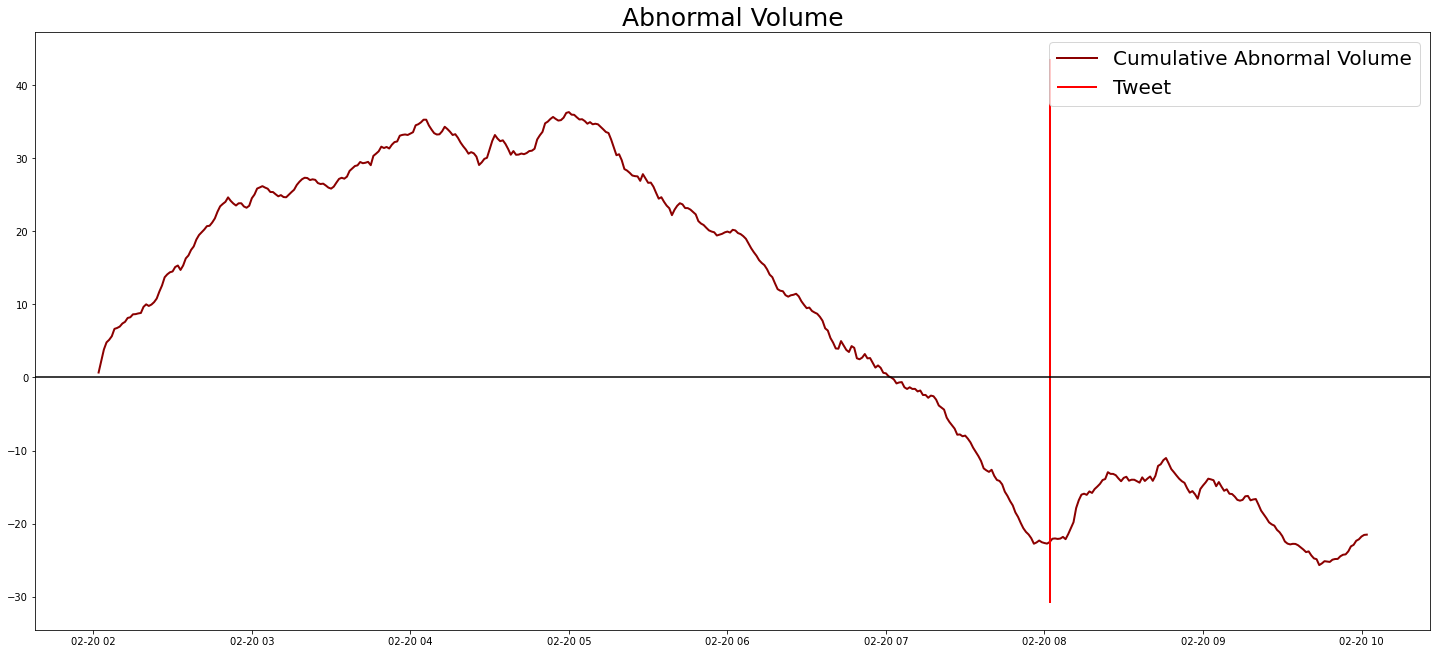

Expected Volume =  13.925533738219801
T[0; 1] =  -29.391829763655217
T[0; 5] =  -2.105841446122077
T[0; 10] =  -3.232401079628851
T[0; 30] =  -7.818051219795866
T[0; 60] =  -11.183601154476532
T[0; 120] =  -15.6612200845633


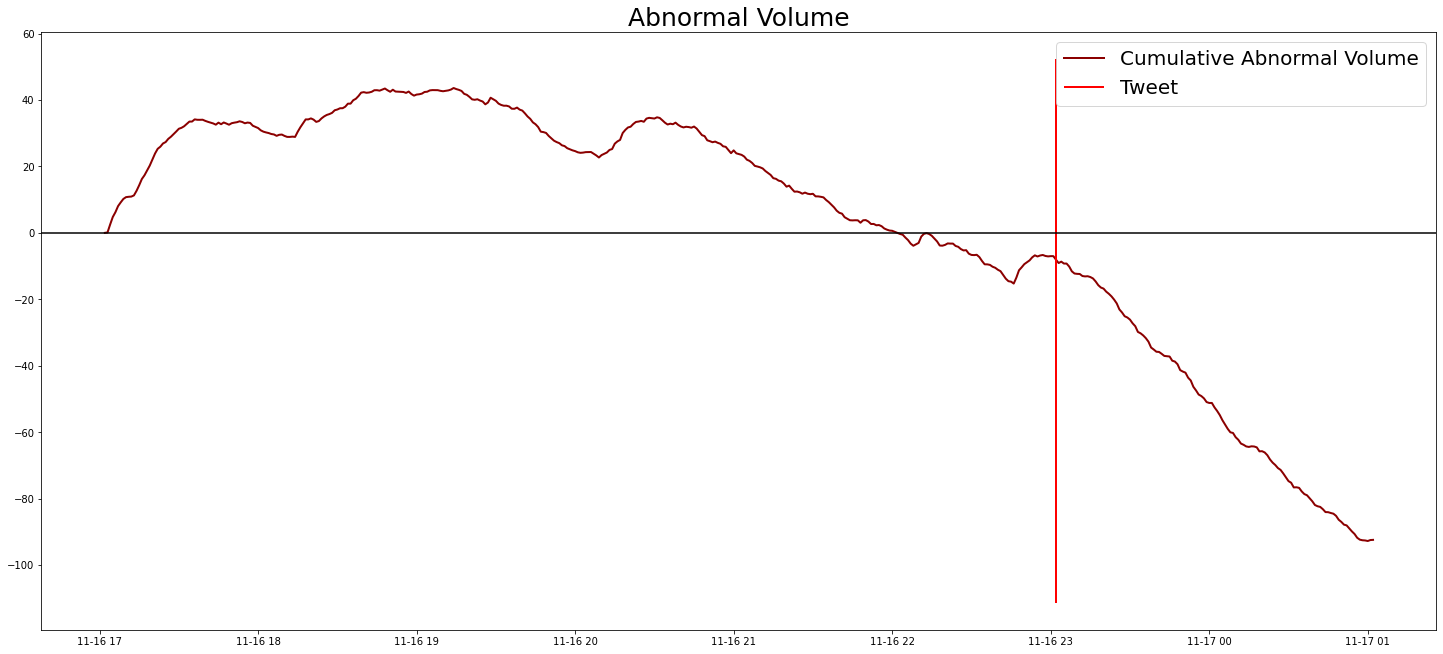

Expected Volume =  14.21265846889777
T[0; 1] =  -1.7939947200458697
T[0; 5] =  -3.5552253487856937
T[0; 10] =  -0.43098699115266786
T[0; 30] =  -0.7000190379979527
T[0; 60] =  1.3995042977320358
T[0; 120] =  -0.6412127943632072


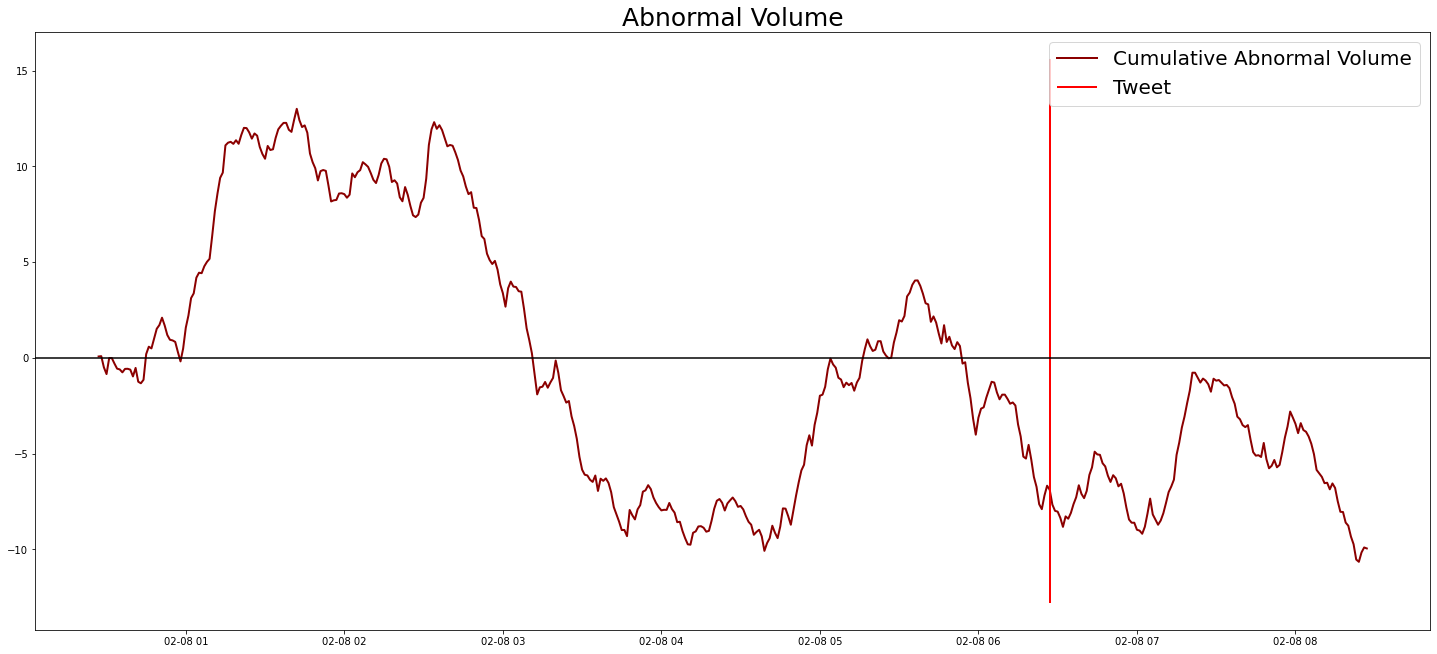

Expected Volume =  14.769545025404618
T[0; 1] =  -1.9896263571511343
T[0; 5] =  -2.0642614356844082
T[0; 10] =  -1.8816751344841491
T[0; 30] =  -7.034547239287051
T[0; 60] =  -5.284515449179588
T[0; 120] =  -10.638841818697948


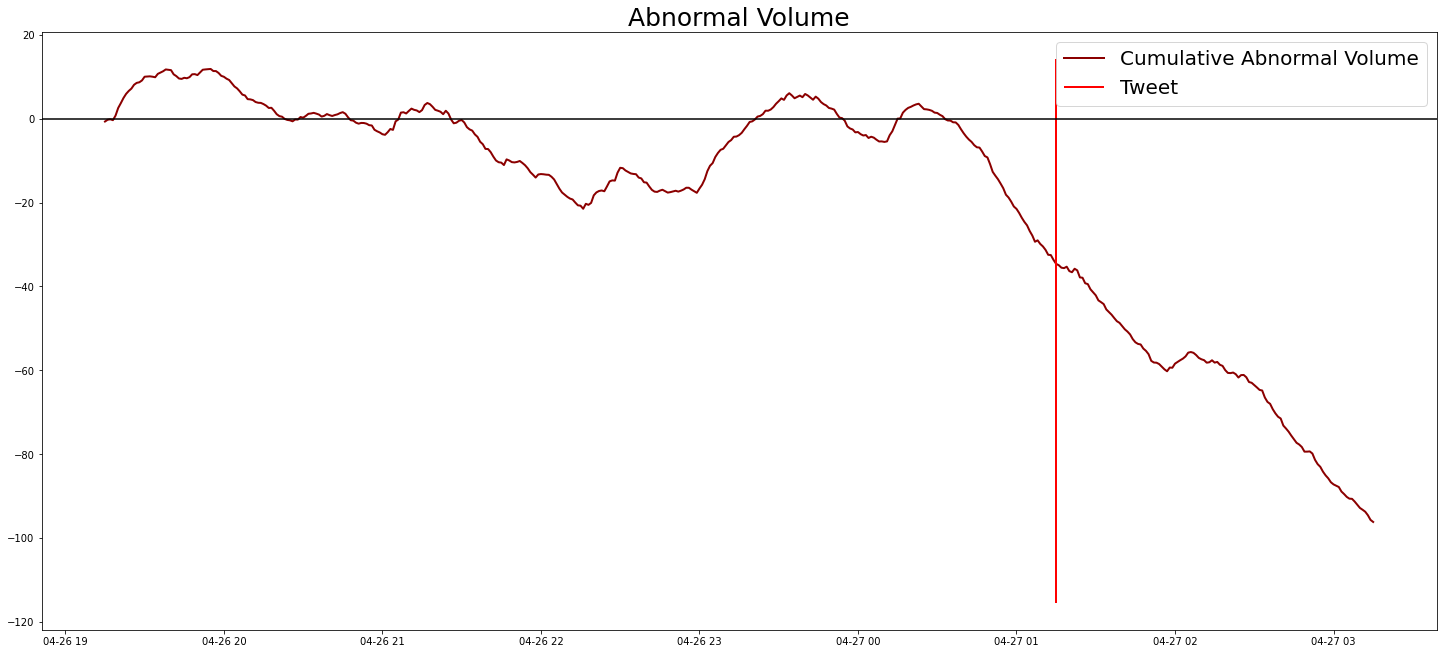

Expected Volume =  15.068906205543291
T[0; 1] =  1.0392150702614342
T[0; 5] =  0.00967087052903213
T[0; 10] =  -1.804396666049905
T[0; 30] =  -3.787482982962233
T[0; 60] =  -6.16200733970038
T[0; 120] =  -6.398342826307026


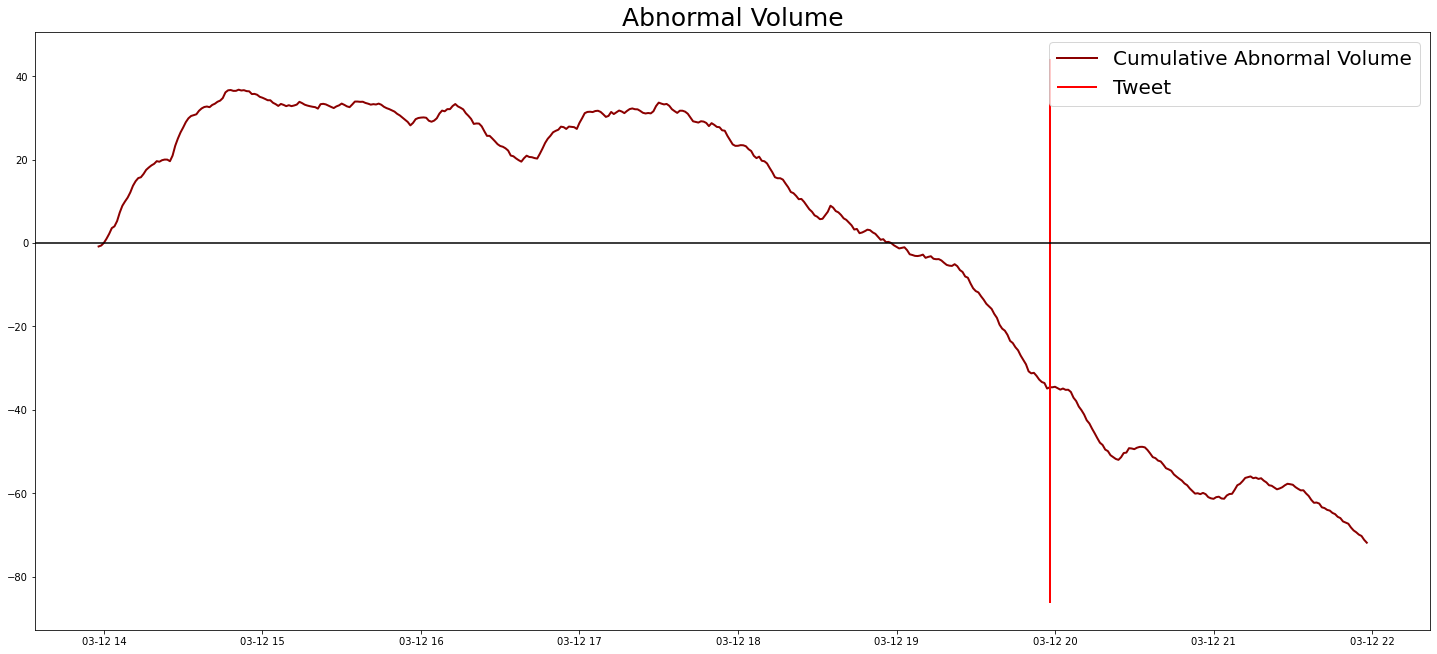

Expected Volume =  15.023467795268024
T[0; 1] =  0.8116649061425891
T[0; 5] =  3.9588730600732696
T[0; 10] =  7.3642201256119435
T[0; 30] =  12.647993927497945
T[0; 60] =  15.37775069784922
T[0; 120] =  19.404790283636817


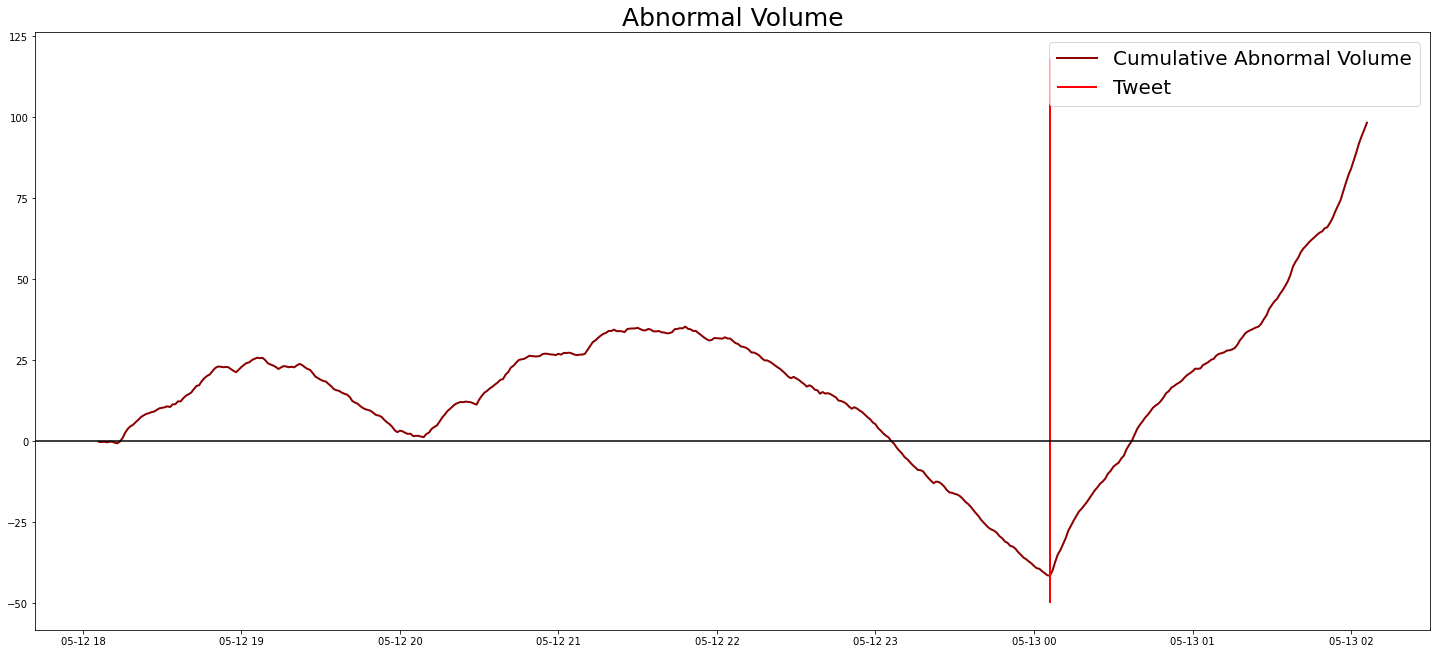

atv_frame:
      ATV_0     ATV_1     ATV_2     ATV_3     ATV_4     ATV_5     ATV_6  \
0  0.226371  0.442778  0.039438 -0.065073    0.0467  0.229855 -0.312812   
1  -1.07371 -1.003052  0.417885 -0.574676  0.005021 -0.907989 -1.437073   
2 -0.218768 -0.769826 -0.323354 -0.041934 -0.322474 -0.472836  0.547073   
3 -0.956395 -0.316586 -0.595856 -0.103652  0.343007 -1.048871  -0.27345   
4  0.297212  0.005716  0.120751 -0.348869 -0.336934  0.268913 -0.316857   
5 -0.162517  1.563312  2.677248  2.333542  1.359361  1.859642  1.820112   

      ATV_7     ATV_8     ATV_9    ATV_10  
0  0.699467  0.797146  0.829562  1.942938  
1 -0.657753 -0.101897 -0.040535 -0.609833  
2 -0.122037  0.302592  0.458784  0.358679  
3  0.832208 -0.386328 -1.675917 -0.085526  
4  0.022417 -0.535446 -1.375826 -0.803629  
5   2.35123  1.474588  1.585257  1.374253  
catv_frame:
     CATV_1    CATV_2    CATV_5    CATV_10    CATV_30    CATV_60    CATV_120
0  0.669148  0.708586  0.920068   4.876369    8.61874   8.892976  

In [139]:
# Volume
pd.options.mode.chained_assignment =None
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))


atv_ges = pd.DataFrame(columns=['ATV_0', 'ATV_1', 'ATV_2', 'ATV_3', 'ATV_4', 'ATV_5', 'ATV_6', 'ATV_7', 'ATV_8', 'ATV_9', 'ATV_10'])
catv_ges = pd.DataFrame(columns = ['CATV_1', 'CATV_2', 'CATV_5', 'CATV_10', 'CATV_30', 'CATV_60', 'CATV_120'])

cum_abnormal_volume_all = []

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    btc_sliced = df[(df['timestamp'] >= timestamp-360*60) & (df['timestamp'] <= timestamp+120*60)]

    # Es werden nach Tweets gesucht, die 240 Minuten vor und 100 Minuten nach dem Event stattgefunden haben.
    tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-240*60) & (df_tweets['timestamp'] <= timestamp+100*60)]
    
    # Ausrechnen der Renditen
    btc_sliced["log_vol"] = np.log(btc_sliced['Quote Asset Volume']+1)
    
    ###################################################################################################################
    # Kumulierte Renditen
    btc_sliced['cum_log_vol'] = np.cumsum(btc_sliced['log_vol'])
    ###################################################################################################################

    # Expected Volume which are based on the mean value of the returns of the last 5 hours before the tweet.
    # Event Takes place at t=360
    expected_volume = np.mean(btc_sliced['log_vol'].iloc[:301]) # Fehler bei Ante, da Ante 1:301 nimmt und nicht 0:300? --> Upper bound excluded
    print('Expected Volume = ', expected_volume)
    
    # Abnormal Returns based on After Returns - Mean Value of Returns (before Tweet)
    btc_sliced['abnormal_volume'] = btc_sliced['log_vol'] - expected_volume
    btc_sliced['abnormal_volume_cum'] = np.cumsum(btc_sliced['abnormal_volume'])

    cum_abnormal_volume_all.append(btc_sliced['log_vol'].values)


    atv_values = []
    for event_horizon in range(11):
        atv_values.append(btc_sliced['abnormal_volume'].iloc[360+event_horizon])
    atv_ges = pd.concat([atv_ges, pd.DataFrame([atv_values], columns=atv_ges.columns)], ignore_index=True)


    catv_values = []
    for event_horizon in [1, 2, 5, 10, 30, 60, 120]:
        catv_values.append(btc_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].sum())
    catv_ges = pd.concat([catv_ges, pd.DataFrame([catv_values], columns=catv_ges.columns)], ignore_index=True)

    # T-Statistiken für [1, 5, 10, 30, 60, 120]
    for event_horizon in [1, 5, 10, 30, 60, 120]:
        print(f'T[0; {event_horizon}] = ', (btc_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].mean() / btc_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1)) # <-- richtiger Wert
        
    fig = plt.figure(1, figsize = (25, 11))
    # plt.plot(btc_sliced["Date"], btc_sliced['cum_log_vol'], lw=2, label='Cumulative Volume')
    plt.plot(btc_sliced["Date"], btc_sliced['abnormal_volume_cum'], lw=2, label='Cumulative Abnormal Volume', color='darkred')
    plt.vlines(dt.fromtimestamp(timestamp), label='Tweet', ymin=btc_sliced['abnormal_volume_cum'].min()*1.2, ymax=btc_sliced['abnormal_volume_cum'].max()*1.2, colors='red', lw=2) 

    if len(tweets_sliced) > 1:
        plt.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=btc_sliced['abnormal_volume_cum'].max()*1.2, colors='orange', lw=2) 
    plt.axhline(0, color = 'black')
    plt.legend(loc='best', fontsize=20)
    plt.title('Abnormal Volume', size=25)

    plt.show()

print('atv_frame:')
print(atv_ges)

print('catv_frame:')
print(catv_ges)

cum_abnormal_volume_all = pd.DataFrame(cum_abnormal_volume_all)
cum_abnormal_volume_all.to_csv('cum_abnormal_volume_all_btc.csv', index=False)

In [140]:
for s in atv_ges.columns:
    print(s)
    print('mean: ', atv_ges[s].mean())
    print('pos: ', sum(atv_ges[s] > 0) / len(atv_ges[s]))
    print('t-stat: ', atv_ges[s].mean() / atv_ges[s].std() * np.sqrt(len(atv_ges[s])))

    test_statistic, p_value = wilcoxon(atv_ges[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(atv_ges[s].mean(), 3), ' & ', 
          np.round(atv_ges[s].mean() / atv_ges[s].std() * np.sqrt(len(atv_ges[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(atv_ges[s] > 0) / len(atv_ges[s])*100, 0)), '\%', sep='')
    print('\n')

ATV_0
mean:  -0.3146347421310202
pos:  0.3333333333333333
t-stat:  -1.3266458935066687
z-stat: 7.0
p-Wert: 0.5625
-0.315 & -1.33 & 7.0 & 33\%


ATV_1
mean:  -0.01294324708488522
pos:  0.5
t-stat:  -0.03403762785472886
z-stat: 10.0
p-Wert: 1.0
-0.013 & -0.03 & 10.0 & 50\%


ATV_2
mean:  0.3893518530706042
pos:  0.6666666666666666
t-stat:  0.8113578877941807
z-stat: 8.0
p-Wert: 0.6875
0.389 & 0.81 & 8.0 & 67\%


ATV_3
mean:  0.1998896773342329
pos:  0.16666666666666666
t-stat:  0.4596123647599601
z-stat: 6.0
p-Wert: 0.4375
0.2 & 0.46 & 6.0 & 17\%


ATV_4
mean:  0.18244679268241212
pos:  0.6666666666666666
t-stat:  0.7091859554128108
z-stat: 7.0
p-Wert: 0.5625
0.182 & 0.71 & 7.0 & 67\%


ATV_5
mean:  -0.011881248716757812
pos:  0.5
t-stat:  -0.02718430580644033
z-stat: 

9.0
p-Wert: 0.84375
-0.012 & -0.03 & 9.0 & 50\%


ATV_6
mean:  0.0044987205648290285
pos:  0.3333333333333333
t-stat:  0.010101472831178553
z-stat: 10.0
p-Wert: 1.0
0.004 & 0.01 & 10.0 & 33\%


ATV_7
mean:  0.520921851482659
pos:  0.6666666666666666
t-stat:  1.2133086004345321
z-stat: 5.0
p-Wert: 0.3125
0.521 & 1.21 & 5.0 & 67\%


ATV_8
mean:  0.2584427067167813
pos:  0.5
t-stat:  0.8245848794620402
z-stat: 8.0
p-Wert: 0.6875
0.258 & 0.82 & 8.0 & 50\%


ATV_9
mean:  -0.036445657187511436
pos:  0.5
t-stat:  -0.07010955779699585
z-stat: 10.0
p-Wert: 1.0
-0.036 & -0.07 & 10.0 & 50\%


ATV_10
mean:  0.36281365947022043
pos:  0.5
t-stat:  0.8094260767666621
z-stat: 8.0
p-Wert: 0.6875
0.363 & 0.81 & 8.0 & 50\%




In [141]:
for s in catv_ges.columns:
    print(s)
    print('mean: ', catv_ges[s].mean())
    print('pos: ', sum(catv_ges[s] > 0) / len(catv_ges[s]))
    print('t-stat: ', catv_ges[s].mean() / catv_ges[s].std() * np.sqrt(len(catv_ges[s])))

    test_statistic, p_value = wilcoxon(catv_ges[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(catv_ges[s].mean(), 3), ' & ', 
          np.round(catv_ges[s].mean() / catv_ges[s].std() * np.sqrt(len(catv_ges[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(catv_ges[s] > 0) / len(catv_ges[s])*100, 0)), '\%', sep='')
    print('\n')

CATV_1
mean:  -0.3275779892159054
pos:  0.5
t-stat:  -0.6059112052603155
z-stat: 8.0
p-Wert: 0.6875
-0.328 & -0.61 & 8.0 & 50\%


CATV_2
mean:  0.06177386385469882
pos:  0.5
t-stat:  0.06732768694795009
z-stat: 9.0
p-Wert: 0.84375
0.062 & 0.07 & 9.0 & 50\%


CATV_5
mean:  0.432229085154586
pos:  0.5
t-stat:  0.22162754823525782
z-stat: 9.0
p-Wert: 0.84375
0.432 & 0.22 & 9.0 & 50\%


CATV_10
mean:  1.5424603662015646
pos:  0.3333333333333333
t-stat:  0.41957105210867335
z-stat: 10.0
p-Wert: 1.0
1.542 & 0.42 & 10.0 & 33\%


CATV_30
mean:  -1.3319634542921588
pos:  0.3333333333333333
t-stat:  -0.13992902062717036
z-stat: 8.0
p-Wert: 0.6875
-1.332 & -0.14 & 8.0 & 33\%


CATV_60
mean:  -2.6807119887235893
pos:  0.5
t-stat:  -0.1668156638166177
z-stat: 9.0
p-Wert: 0.84375
-2.681 & -0.17 & 9.0 & 50\%


CATV_120
mean:  -7.875512530319942
pos:  0.3333333333333333
t-stat:  -0.24221408459478458
z-stat: 7.0
p-Wert: 0.5625
-7.876 & -0.24 & 7.0 & 33\%




In [142]:
atv_ges.to_csv('atv_ges_bitcoin.csv', index=False)
catv_ges.to_csv('catv_ges_bitcoin.csv', index=False)